# ***Living Earth*** Evidence-based change - impacts and pressures <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)

## The Evidence-Based Change Framework

Within *Living Earth*, **land cover** maps are constructed from environmental descriptors retrieved or classified from Earth observation data according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (LCCS).  The use of environmental descriptors with defined units (e.g., m, %) and categories ensures scalability in space and time. 

For change mapping, an Evidence-Based Change Framework has been established [Lucas et al. 2022](https://onlinelibrary.wiley.com/doi/full/10.1111/gcb.16346), which links the FAO LCCS temporally-derived land cover maps with the **Driver-Pressure-State-Impact-Response (DPSIR)** Framework.

Comparisons of Overarching Environmental Descriptors (OEDs), that correspond to the eight broad land cover types of the FAO LCCS Level 3, establishes what are termed **observed changes**.  These reference the transition matrix between these classes to establish changes in land cover extent (conversions) or otherwise (i.e., areas where modifications might have occurred).

Essential Environmental Descriptors (EEDs) are those used to construct the FAO LCCS in its entirety, recognising that these might not be available from remote sensing or other sources.  Time-series comparison of one or several EEDs allows modifications of land covers to be identified (or otherwise). Additional Environmental Descriptors (AEDs) are not used in the construction of the FAO LCCS but provide further quantitative or qualitative (categorical) descriptions with examples being above ground biomass (Mg ha-1) or plant species type respectively.  

**Impacts** are determined by gathering evidence from the comparisons of EEDs and/or OEDs, with this based on past knowledge (e.g., scientific studies) and/or observations.   

Within DPSIR, impacts are the consequence of **pressures** associated with drivers including climate, tectonics, economy or war.   

The Evidence-based Change Framework identifies, defines and describes 77 impacts and 144 pressures that and combines these to generate 246 **'impact-pressure'** categories.   


## Description 
This notebook accesses the FAO LCCS layer at Level 3 (Basic; 6 classes) but also Level 4 (over 100 classes) to gather evidence for impacts and associates these with aligned pressure categories. This is achieved by:

1. Loading and displaying DEA land cover classifications (basic and detailed) and contributing environmental descriptors for an area of interest.
2. Determing areas of land cover conversions (losses and gains) based on time-series comparison of the land cover maps between two years.
3. Determining areas of no change in the FAO LCCS Level 3 classes where there is potential for a modification to occur. 
4. Comparing the lifeform, water persistence and canopy cover categories of the FAO LCCS Level 3 to indicate forms of modification.
5. Allowing the pressures leading to the change to be explored through drop down menus. 
6. Combining this information as evidence to map different impacts as listed in the (Global Change Taxonomy](https://onlinelibrary.wiley.com/doi/full/10.1111/gcb.16346)

This notebook requires a basic understanding of the DEA Land Cover data set.  For more information, visit [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

## Getting started

To run this analysis, run all the cells in the notebook starting with the 'Load packages and connect to the datacube' cell.

### Load packages
Load key Python packages and supporting functions for the analysis.  Note that these have been moved to a file called Tools_and_libraries.py.  

In [1]:
from Tools_and_libraries import *
# Ensure openpyxl is installed
!pip install openpyxl

added a new line here
another line


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/36951/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/36951/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43853,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/36951/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:33193,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/43863/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:38413,


2025-03-02 05:59:02,296 - distributed.nanny - WARNING - Restarting worker
2025-03-02 05:59:02,418 - distributed.nanny - WARNING - Restarting worker
2025-03-02 05:59:02,715 - distributed.nanny - WARNING - Restarting worker
2025-03-02 05:59:03,721 - distributed.nanny - WARNING - Restarting worker


### Connect to the datacube
Connect to the datacube to access Digital Earth Australia's (DEA) land cover data. 

In [2]:
dc = datacube.Datacube(app="Observed Change - Impacts")

## Select and view your area of interest
Select your area of interest by through interactive selection, use of rectangular coordinates or through uploading of a shapefiles or geojson.  A number of example areas are provided in your uploads directory (as geojsons) but you can select an area of your choice.

For the inital run, select the geojson file ***"Ngarkat_files.geojson"***  from the uploads directory"

In [3]:
from ipyleaflet import Map, DrawControl, Rectangle, WidgetControl, LayersControl, FullScreenControl, GeoJSON, basemaps
from ipywidgets import Button, VBox, Tab, FloatText, Output, Layout, HBox, HTML, Dropdown
from shapely.geometry import Polygon
import gc
import geopandas as gpd
from ipyfilechooser import FileChooser
import json

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None
geojson_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widgets to display coordinates
output_draw = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_manual = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_load = Output(layout={'border': '1px solid black', 'padding': '5px'})

### Draw Method ###
# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output_draw.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output_draw:
        output_draw.append_stdout("Coordinates:\n")
        output_draw.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output_draw.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')

# Event handler for the clear button
def clear_all_draw(b):
    global selected_polygon, lat_range, lon_range
    draw_control.clear()
    output_draw.clear_output()
    selected_polygon = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_draw.on_click(clear_all_draw)

draw_tab = VBox([clear_button_draw, output_draw])

### Manual Input Method ###
# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output_manual.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output_manual:
            output_manual.append_stdout("Manual Coordinates:\n")
            output_manual.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output_manual:
            output_manual.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Button to clear manual input and output
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all_manual(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    output_manual.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_manual.on_click(clear_all_manual)

manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output_manual])

### Load Method ###
# File chooser to load shapefile or GeoJSON
file_chooser = FileChooser(filter_pattern=['*.shp', '*.geojson'])
load_button = Button(description='Load File')

# Function to load and display shapefile or GeoJSON
def load_file(b):
    global geojson_layer, selected_polygon, lat_range, lon_range
    output_load.clear_output()
    
    file_path = file_chooser.selected
    
    if file_path:
        if file_path.endswith('.shp'):
            gdf = gpd.read_file(file_path)
            geo_json_data = json.loads(gdf.to_json())
        elif file_path.endswith('.geojson'):
            with open(file_path) as f:
                geo_json_data = json.load(f)
        
        if geojson_layer:
            m.remove_layer(geojson_layer)
        
        geojson_layer = GeoJSON(data=geo_json_data, style={'color': 'green', 'fillOpacity': 0.5})
        m.add_layer(geojson_layer)
        
        coords = geo_json_data['features'][0]['geometry']['coordinates'][0]
        selected_polygon = Polygon(coords)
        lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
        lat_range = (min(lats), max(lats))
        lon_range = (min(lons), max(lons))
        
        m.fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])
        
        with output_load:
            output_load.append_stdout(f"Loaded {file_path}\n")
            output_load.append_stdout("Coordinates:\n")
            output_load.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            for lat, lon in zip(lats, lons):
                output_load.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")
    else:
        with output_load:
            output_load.append_stdout("Please select a file.\n")

load_button.on_click(load_file)

# Load method tab layout
load_tab = VBox([file_chooser, load_button, output_load])

### Main Method Selection Tab ###
# Add all tabs to the main method selection tab
method_tab = Tab()
method_tab.children = [draw_tab, manual_tab, load_tab]
method_tab.set_title(0, 'Draw Method')
method_tab.set_title(1, 'Manual Input Method')
method_tab.set_title(2, 'Load Method')

# Add the method selection tab control to the map
method_control = WidgetControl(widget=method_tab, position='topright')
m.add_control(method_control)

# Create a subtle tab for collapsing/expanding the menu using Button
collapse_button = Button(description=">", layout=Layout(width='30px', height='30px'))

# Event handler for the collapse/expand button
def toggle_collapse(b):
    if method_control in m.controls:
        m.remove_control(method_control)
        collapse_button.description = "<"
    else:
        m.add_control(method_control)
        collapse_button.description = ">"

collapse_button.on_click(toggle_collapse)

# Add the collapse button to the map
collapse_control = WidgetControl(widget=collapse_button, position='topright')
m.add_control(collapse_control)

# Display the map
display(m)

print("Draw, Manual Input, and Load methods setup with menu toggle completed.")

# Manually invoke garbage collection
gc.collect()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Draw, Manual Input, and Load methods setup with menu toggle completed.


1172

# Define dates and/or period of interest
Select the time-period of interest, which can be for any year from 1988 to 2020.  When using the date selection, ideally select the 1st January for the start year and the 31st December for the end year.

In [4]:
from ipywidgets import VBox, Button, DatePicker, Output
from IPython.display import display
from datetime import datetime  # Import datetime

# DatePicker widgets with initial default values
start_date_input = DatePicker(
    description="Start Date",
    value=datetime(2010, 1, 1)  # Default start date
)

end_date_input = DatePicker(
    description="End Date",
    value=datetime(2020, 12, 31)  # Default end date
)

# Define update button
update_button = Button(description="Update Date Range")

# Output area for displaying messages
output = Output()

# Define the button click event
def on_button_click(b):
    with output:
        output.clear_output()  # Clear previous output
        start_date = start_date_input.value
        end_date = end_date_input.value
        
        # Check if both dates are selected
        if start_date is None or end_date is None:
            print("Please select both start and end dates.")
            return
        
        # Check if start date is before end date
        if start_date > end_date:
            print("Start date must be before end date.")
            return
        
        # Confirmation message for valid date selection
        print(f"Date range selected: {start_date} to {end_date}")
        print("Date range confirmed. You may proceed with further actions.")
        
        # Example placeholder for additional processing
        # Replace this with any data loading or processing code
        print("Processing data for the selected date range...")

# Attach the callback to the button
update_button.on_click(on_button_click)

# Display widgets, button, and output area
display(VBox([start_date_input, end_date_input, update_button, output]))

**Note: ** The date range is automatically updated.

## Load and view the Environmental Descriptors (EDs)
The following cell will load what are termed the Environmental Descriptors (EDs) used to construct the Basic (Level 3) and subsequently the Detailed (Level 4) land cover maps for the `lat_range`, `lon_range` and `time_range` defined for your area of interest.

In [7]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import HTML, VBox
from IPython.display import display
import time
import logging
import threading
import gc

# Suppress garbage collection warnings
logging.getLogger("distributed.utils_perf").setLevel(logging.ERROR)

# Create a dot indicator
spinner = HTML("<b>.</b>")
box = VBox([spinner])
display(box)

# Function to update the spinner
def spin():
    while not done:
        spinner.value = spinner.value + "." if len(spinner.value) < 10 else "<b>.</b>"
        time.sleep(0.5)

# Assume total steps is the number of files/jobs being loaded
total_steps = 10  # Replace with the actual number of steps

# Ensure actual data loading for DEA Land Cover data
done = False
try:
    # Start the spinner in a separate thread
    spinner_thread = threading.Thread(target=spin)
    spinner_thread.start()
    
    # Step 1: Check if required variables are defined
    if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
        raise ValueError("Latitude, Longitude, or Time range is not defined")

    print("Lat Range:", lat_range)
    print("Lon Range:", lon_range)
    print("Start Date:", start_date_input.value)
    print("End Date:", end_date_input.value)

    # Step 2: Construct the query
    query = {
        "y": lat_range,
        "x": lon_range,
        "time": (start_date_input.value, end_date_input.value),
    }

    print("Query Parameters:", query)
  
    # Step 3: Load DEA Land Cover data from the datacube
    with tqdm(total=total_steps, desc="Loading DEA Land Cover data", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        lc = dc.load(
            product="ga_ls_landcover_class_cyear_2",
            output_crs="EPSG:3577",
            measurements=[
                "level3",
                "lifeform",
                "vegetation_cover",
                "water_seasonality",
                "water_state",
                "intertidal",
                "water_persistence",
                "bare_gradation",
                "full_classification",
            ],
            resolution=(-25, 25),
#            dask_chunks={'time': 1},
            **query
        ).persist()
        
        # Update the progress bar after each step
        pbar.update(1)  # Adjust the value if multiple steps are combined into one

        # Simulate further steps if necessary
        for _ in range(total_steps - 1):
            time.sleep(0.1)  # Simulate a step taking time
            pbar.update(1)

    pbar.close()  # Close the progress bar to remove it from the output
    print("DEA Land Cover data loaded successfully.")
except Exception as e:
    print(f"Error loading DEA Land Cover data: {e}")
finally:
    # Stop the spinner
    done = True
    spinner_thread.join()

# Remove the spinner
box.close()

# Step 4: Check if the dataset is loaded correctly
if 'lc' not in locals() or lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   

# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)

# Free up memory if necessary
_ = gc.collect()  # Suppress the output by assigning it to a variable


Lat Range: (-18.77274440933033, -18.66082864486158)
Lon Range: (146.22519913343797, 146.31272859749703)
Start Date: 1988-01-01
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-18.77274440933033, -18.66082864486158), 'x': (146.22519913343797, 146.31272859749703), 'time': (datetime.date(1988, 1, 1), datetime.datetime(2020, 12, 31, 0, 0))}


Loading DEA Land Cover data:   0%|          | 0/10 [00:00<?]

DEA Land Cover data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]
Dimensions: ('y', 'x')
Resolution: (-25.0, 25.0)
Shape: (536, 423)
Extent: Geometry({'type': 'Polygon', 'coordinates': (((1493875.0, -2078700.0), (1493875.0, -2092100.0), (1504450.0, -2092100.0), (1504450.0, -2078700.0), (1493875.0, -2078700

In [8]:
# Get colour map for image
#cmap, norm = lc_colourmap('level3_change_colour_scheme')

You can view each of these layers using the  `plot_land_cover()` function.

** Note:  You can run one, several or all of these to view the appropriate product.

In [9]:
# Section 6: Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)
item_checkbox = widgets.Checkbox(description='Intertidal Elevation', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

Button(description='Plot Selected Data', style=ButtonStyle())

Output()

## Detecting and describing land cover change 
###  Observed change
Within the Global Change Taxonomy of [Lucas et al. 2020](https://onlinelibrary.wiley.com/doi/10.1111/gcb.16346), the transition matrix between observed broad land cover classes (i.e., OEDs) is used to identify land cover conversions (off-diagonals) and modifications (on-diagonals) between two time-separated periods as well as areas of no change.   

**Note:**  There are 6 classes in the case of Australia as there are limited cultivated aquatic landscapes, and artificial and natural water are merged.

###  Evidence-based change
Once conversions and modifications have been identified, further environmental descriptors are accessed to provide evidence for change.   These include the environmental descriptors of lifeform and water state (categorical) and vegetation cover and annual water hyproperiod (categorical representations of continuous environmental descriptors). These are regarded as Essential Environmental Descriptors (EEDs) as they are needed to construct the land cover categories according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (LCCS) (e.g., Level 3, lifeform, vegetation cover, water state and level 4 (full classification))


### Load the colour scheme for change
You will need to upload colour schemes for both the data and the legend and labels for the maps being generated.

In [10]:
# Import the colour schemes for the land cover change data themselves (i.e. the digital values - e.g., 111111).
from landcover import plot_land_cover, lc_colourmap, make_colorbar 
cmap, norm = lc_colourmap('level3_change_colour_scheme')

# Load myfunctions.py and import the plotting routines for level 3 (gains, losses and non change), lifeform, canopy cover and water persistence.
from myfunctions import plot_level3_gain, plot_level3_loss, plot_level3_no_change, plot_lifeform_changes, plot_canopy_cover_change, plot_water_persistence_change

## Identifying gains in Level 3 classes (conversions)
Changes (gains in land cover) between Time 1 [0] and Time 2 [-1 or the last number in the time-series]] can be identified through the transition matrix.

In [11]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)
ignore_no_change = True
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)

In [12]:
level_3 = lc.level3[0].drop_vars("time")

In [13]:
# Create a new Xarray.DataArray
obs_gain_l3_conversion = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [14]:
obs_gain_l3 = obs_gain_l3_conversion.to_dataset(name="conversion_gain")
del obs_gain_l3_conversion

In [15]:
# Load the colour map for the gains in Level 3 classes
cmap, norm = lc_colourmap('level3_change_colour_gain')

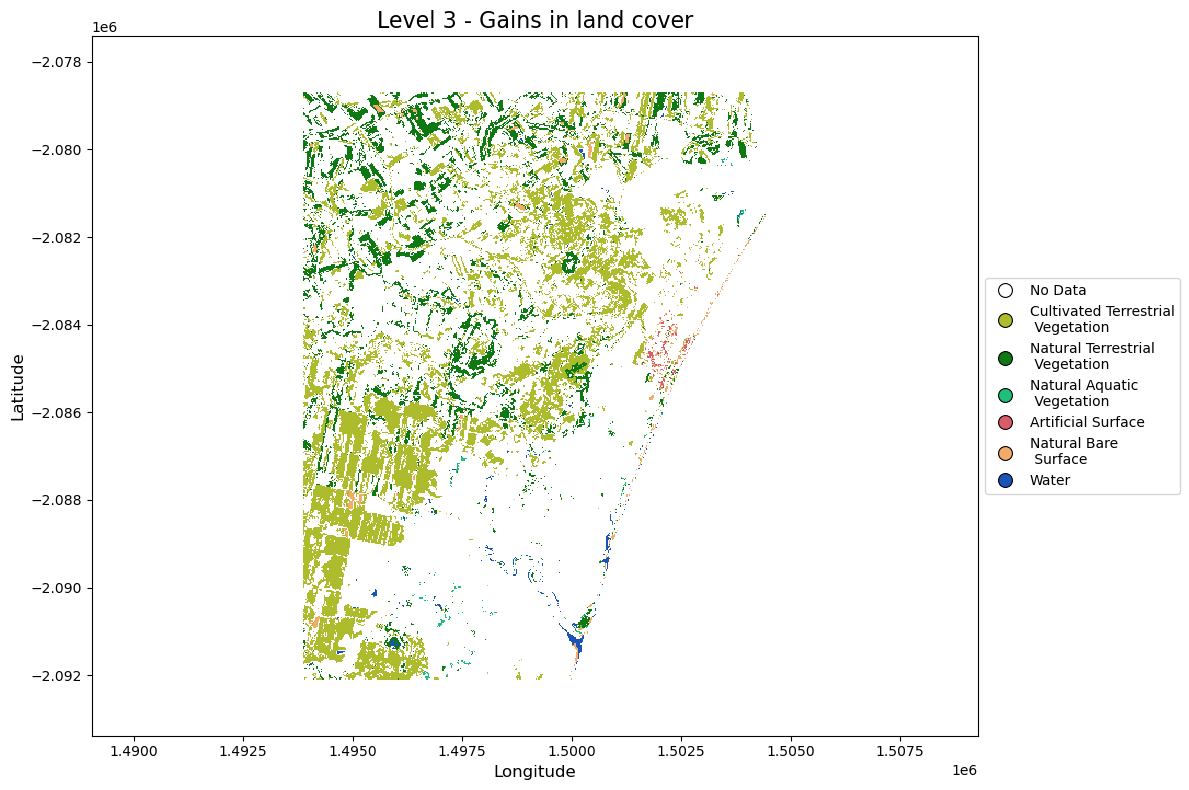

In [16]:
plot_level3_gain(
    data=obs_gain_l3.conversion_gain,
    cmap=cmap,
    norm=norm,
    figsize=(12, 8),
    title='Level 3 - Gains in land cover'
)

#### Saving your file as a png
Note that you might want to save the plot as a .png file and use it later. To this, save into a directory called 'illustrations'

In [17]:
plt.gcf().savefig('./illustrations/level3_gain_plot.png', format='png', dpi=300)
print("Plot saved as './illustrations/level3_gain_plot.png'")

Plot saved as './illustrations/level3_gain_plot.png'


<Figure size 640x480 with 0 Axes>

## Identifying losses in Level 3 classes
Losses in land cover between Time 1 [0] and Time 2 [-1 or the last number in the time-series]] can also be identified through the transition matrix.

#### Identify change (loss) in Level 3 from Time 1 [0] to Time 2 [-1]

In [18]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
# (Note changing to (end * 1000) + start
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
#level_3 = lc.level3[0].drop_vars("time")

In [19]:
# Create a new Xarray.DataArray
obs_loss_l3_conversion= xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed losses",
    attrs=level_3.attrs,
    fastpath=False,
)

In [20]:
obs_loss_l3 = obs_loss_l3_conversion.to_dataset(name="conversion_loss")
del obs_loss_l3_conversion

#### Plot Level 3 losses

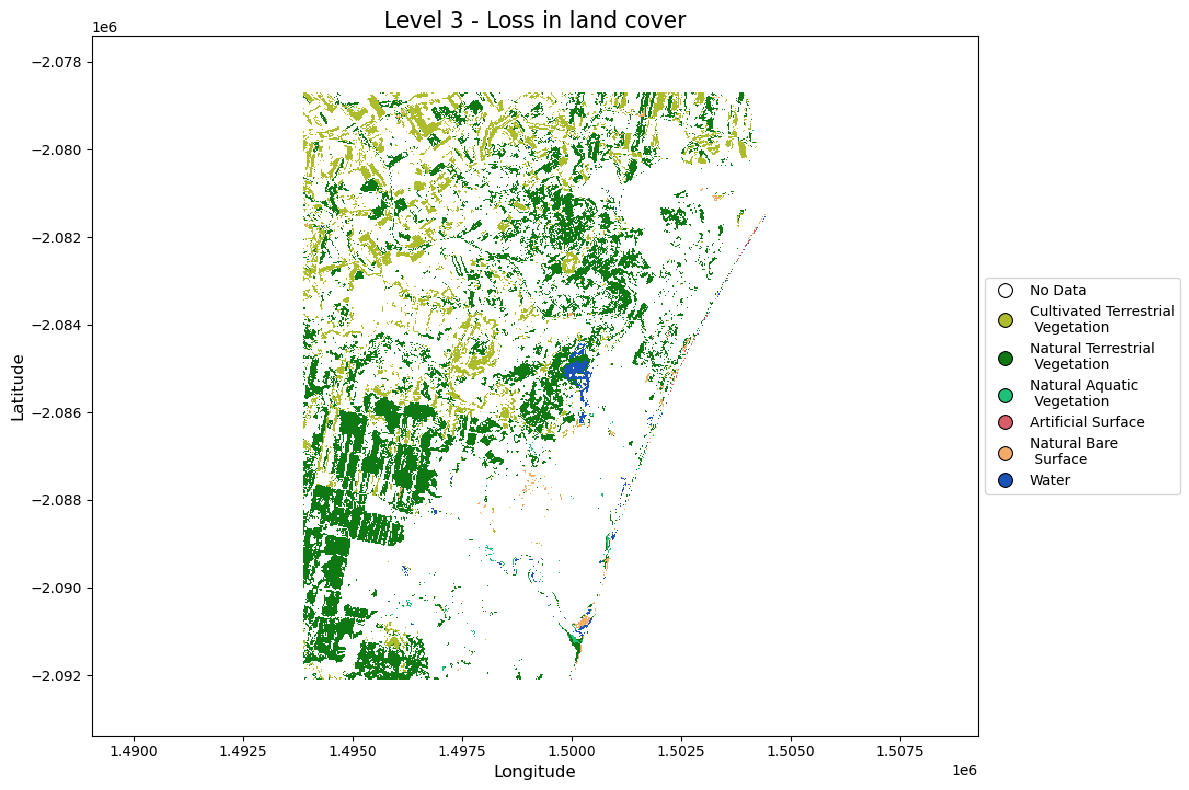

In [21]:
plot_level3_loss(
    data=obs_loss_l3.conversion_loss,
    cmap=cmap,
    norm=norm,
    figsize=(12, 8),
    title='Level 3 - Loss in land cover'
)

### NO CHANGE

#### Areas of no change between Time 1 and Time 2 [-1 or 4]
Some land covers do not change in extent between Time 1 [0] and Time 2 [-1 or the last number in the time-series]] but modifications within these land covers might occur. 

In [22]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)

# Mark if you want to ignore no change
ignore_no_change = False

# Combine classifications from start and end dates
change_vals = (start * 1000) + end

# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
    
level_3 = lc.level3[0].drop_vars("time") 

# Create a new Xarray.DataArray
obs_change_l3_modification = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="no change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [23]:
obs_change_l3 = obs_change_l3_modification.to_dataset(name="modification")
del obs_change_l3_modification

In [24]:
cmap, norm = lc_colourmap('level3_change_colour_scheme')

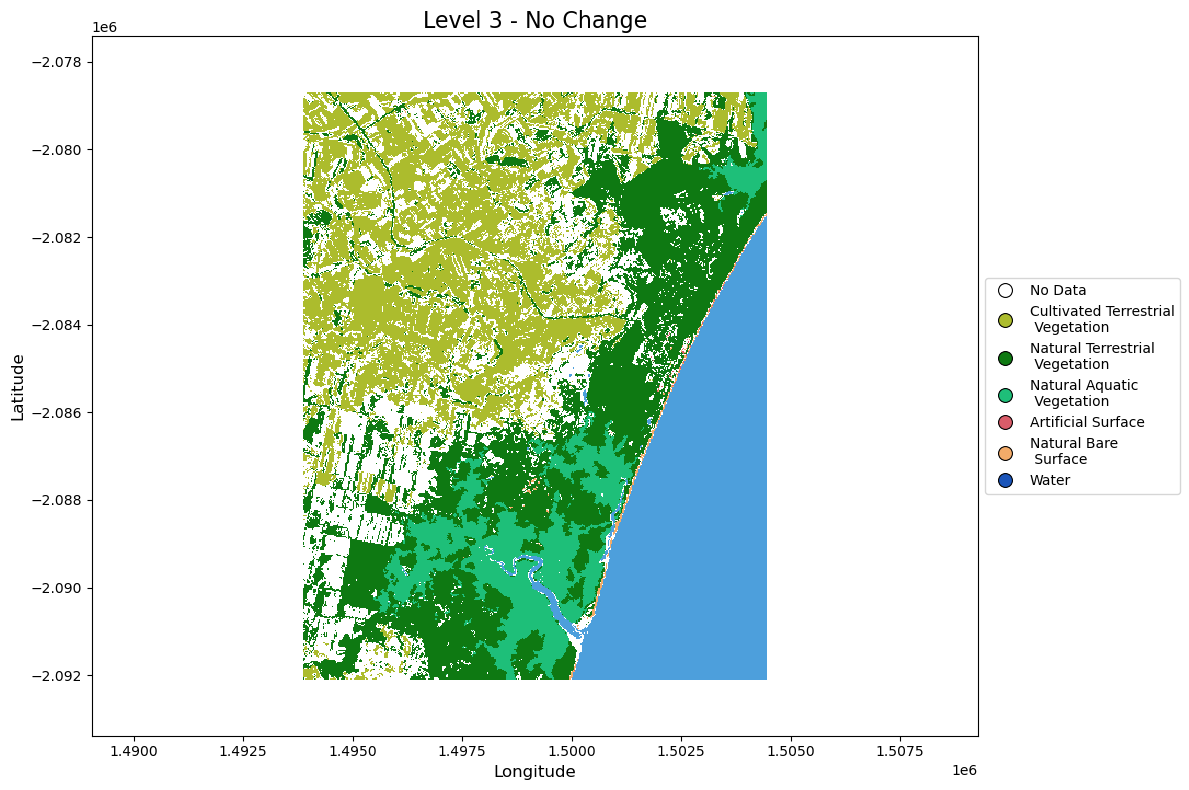

In [25]:
plot_level3_no_change(
    data=obs_change_l3.modification,
    cmap=cmap,
    norm=norm,
    figsize=(12, 8),
    title='Level 3 - No Change'
)

These can be evidenced by considering Essential Environmental Descriptors (EEDs) including lifeform, canopy cover and water persistence.

## Lifeform change maps

#### Change in Lifeform between Time 1 [0] and Time 2 [-1]
Digital Earth Australia (DEA) classifies lifeform according to two [categories](https://livingearth-lccs.readthedocs.io/en/latest/Level4_Layer_Values_AU.html).


| Value | LCCS Code | LCCS Description         |
|-------|-----------|--------------------------|
| 1     | A1        | Woody   |
| 2     | A2        | Herbaceous |


The following generates maps of change by concatenating these values, noting that some areas can go from no vegetation to woody or herbaceous (i.e., 01 or 02), from these categories to no vegetation (i.e., 10 or 20) or remain as non-vegetated (0 to 0).  The lifeform can remain the same (i.e., 11 or 22) or change (i.e. 12 or 21).  The following generates maps of these modifications, which represent a change in type.

In [26]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[0].astype(np.int32)
end = lc.lifeform[-1].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[0].drop_vars("time")

In [27]:
# Create a new Xarray.DataArray
obs_change_lf_modification = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="lifeform change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [28]:
obs_change_lf = obs_change_lf_modification.to_dataset(name="lf_change")

In [29]:
cmap, norm = lc_colourmap('lfchange_colour_scheme')

#### Plot lifeform change

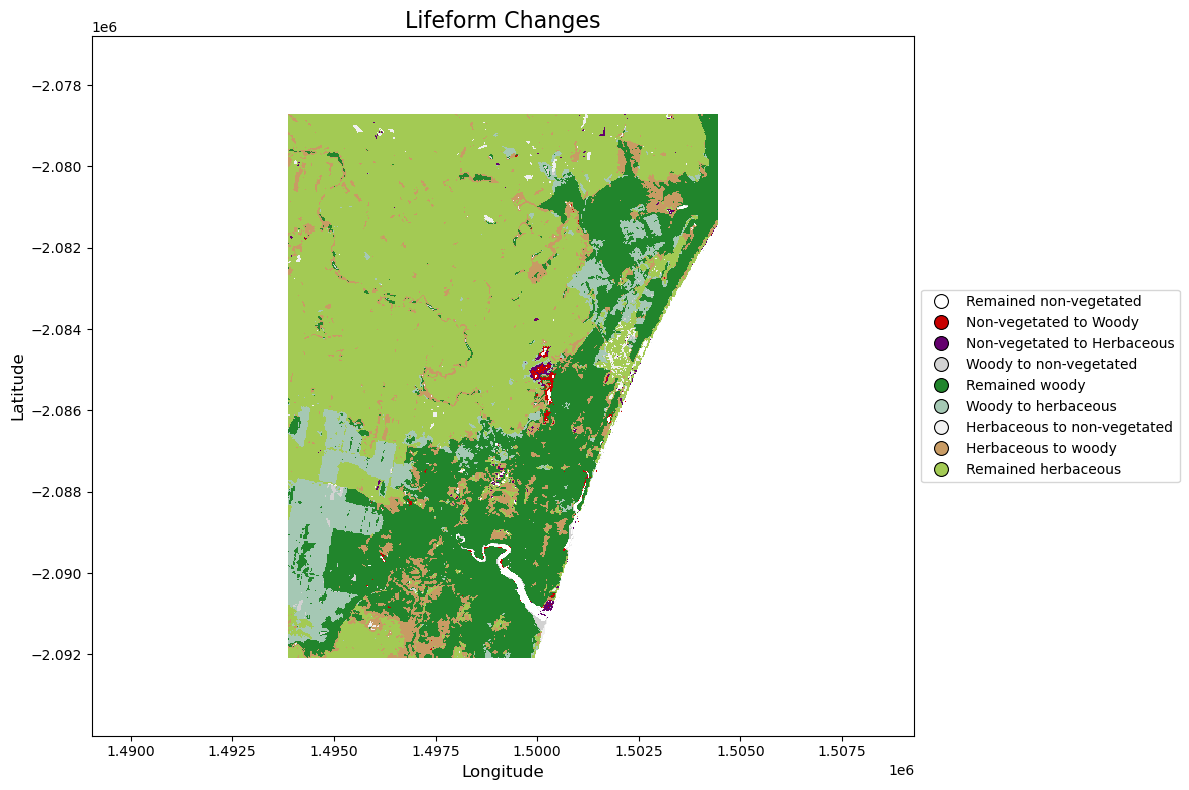

In [30]:
plot_lifeform_changes(
    data=obs_change_lf.lf_change,
    cmap=cmap,
    norm=norm,
    figsize=(12, 8),
    title='Lifeform Changes'
)

### Changes in annual water persistence.
Water is mapped within DEA using through the Water Observations from Space (WOfS) algorithm developed by [Muller et al. (2018)](https://www.sciencedirect.com/science/article/pii/S0034425715301929).  The [categories](https://livingearth-lccs.readthedocs.io/en/latest/Level4_Layer_Values_AU.html for Australia are:

| Value | LCCS Code | LCCS Description         |
|-------|-----------|--------------------------|
| 1     | B1        | Perennial (> 9 months)   |
| 7     | B7        | Non-perennial (7 to 9 months) |
| 8     | B8        | Non-perennial (4 to 6 months) |
| 9     | B9        | Non-perennial (1 to 3 months) |
| 3     |           | Tidal|

Changes between categories are identified by comparing water persistence between years and concatenating the values. For example, a change from water that is perennial (present for > 9 months) to non-perennial is indicated by the value 19.  

The following generates the maps of change based on this comparison.

In [31]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.water_persistence[0].astype(np.int32)
end = lc.water_persistence[-1].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
water_persistence = lc.water_persistence[0].drop_vars("time")

In [32]:
# Create a new Xarray.DataArray
obs_change_wper_modification = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="water persistence change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [33]:
obs_change_wper = obs_change_wper_modification.to_dataset(name="wper_change")

In [34]:
#make_colorbar(fig, axs[2], measurement='wperchange_colour_scheme')
cmap, norm = lc_colourmap('wperchange_colour_scheme')

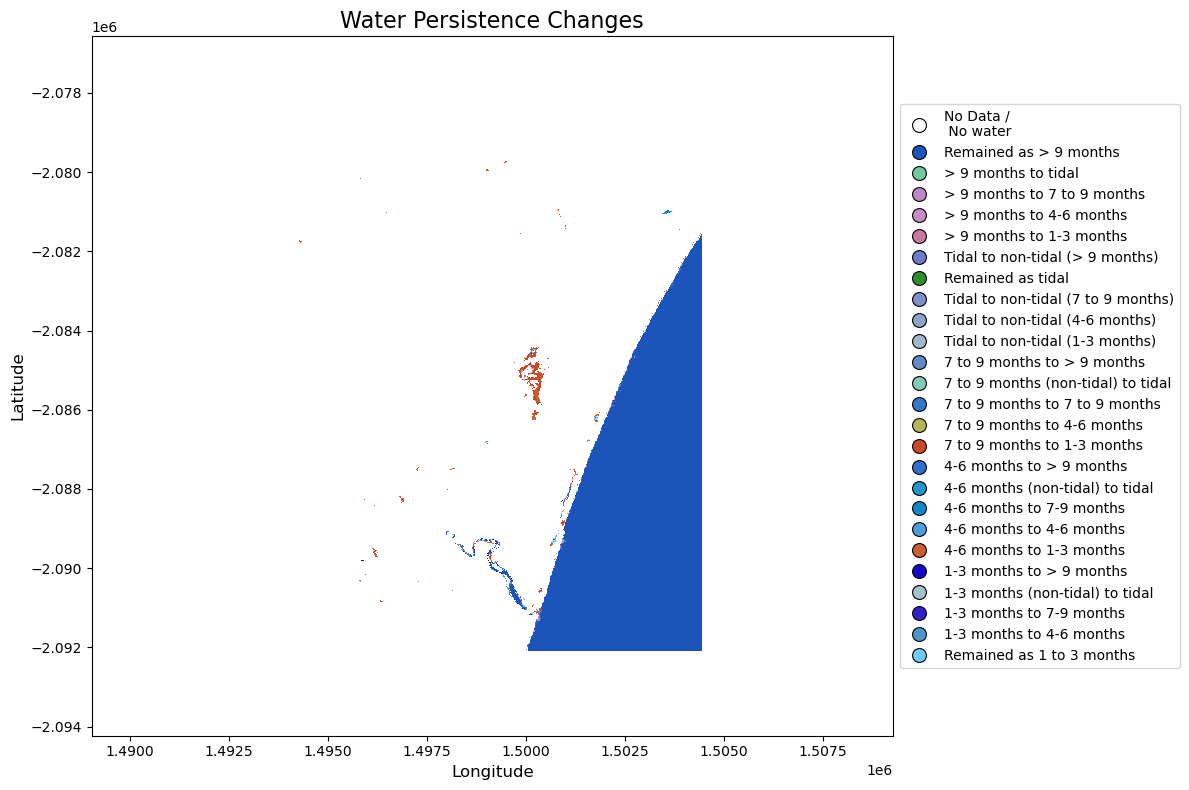

In [35]:
plot_water_persistence_change(
    data=obs_change_wper.wper_change,
    cmap=cmap,
    norm=norm,
    figsize=(12, 8),
    title='Water Persistence Changes'
)

### Vegetation cover changes

Vegetation cover changes are mapped within DEA using through the [fractional cover algorithm](https://knowledge.dea.ga.gov.au/data/product/dea-fractional-cover-landsat/) and combined both the photosynthetic and non-photosynthetic fractions (i.e., total vegetated fraction) over a year.  The [categories](https://livingearth-lccs.readthedocs.io/en/latest/Level4_Layer_Values_AU.html for Australia are:

| Value | LCCS Code | LCCS Description      |
|-------|-----------|-----------------------|
| 10    | A10       | Closed (> 65 %)       |
| 12    | A12       | Open (40 to 65 %)     |
| 13    | A13       | Open (15 to 40 %)     |
| 15    | A15       | Sparse (4 to 15 %)    |
| 16    | A16       | Scattered (1 to 4 %)  |

Changes between vegetation cover categories are identified by comparing and concatenating values between years. For example, a change from vegetation that is closed (A10) to scattered (A16) is represented by the value 1016.   
The following generates the maps of change based on this comparison.

In [36]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)

start = lc.vegetation_cover[0].astype(np.int32)
end = lc.vegetation_cover[-1].astype(np.int32)
ignore_no_change = False
change_vals = (start * 100) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
vegetation_cover = lc.vegetation_cover[0].drop_vars("time")

In [37]:
# Create a new Xarray.DataArray
obs_change_vcov_modification = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="vegetation canopy cover change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [38]:
obs_change_vcov = obs_change_vcov_modification.to_dataset(name="vcov_change")

In [39]:
#make_colorbar(fig, axs[2], measurement='vcovchange_colour_scheme')
cmap, norm = lc_colourmap('vcovchange_colour_scheme')

In [40]:
#obs_change_vcov_2010_2020.plot(cmap=cmap, norm=norm)

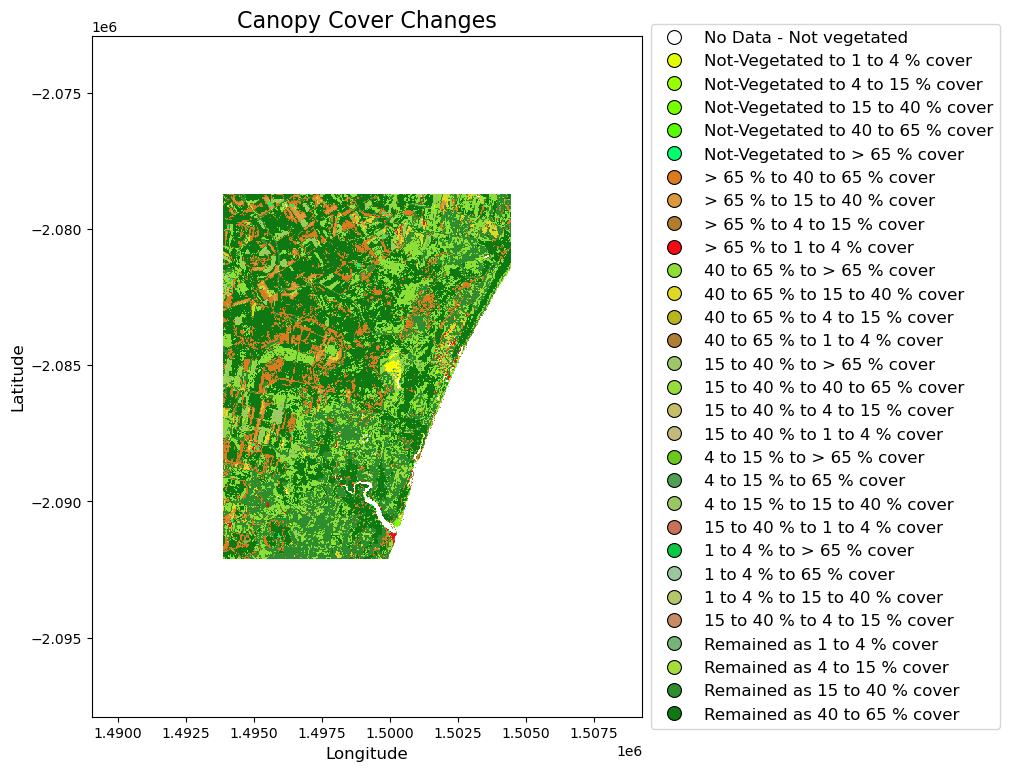

In [41]:
from myfunctions import plot_canopy_cover_change
plot_canopy_cover_change(
    data=obs_change_vcov.vcov_change,
    cmap=cmap,
    norm=norm,
    figsize=(12, 8),
    title='Canopy Cover Changes'
)

In [42]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF of Level 3 gains to an output directory
write_cog(geo_im=obs_gain_l3["conversion_gain"],
          fname='./outputs/level3_conversion_gain.tif',
          overwrite=True)

# Write GeoTIFF of Level 3 losses to an output directory.
write_cog(geo_im=obs_loss_l3["conversion_loss"],
          fname='./outputs/level3_conversion_loss.tif',
          overwrite=True)

# Write GeoTIFF representing areas of no change at Level 3.
write_cog(geo_im=obs_change_l3["modification"],
          fname='./outputs/level3_modification.tif',
          overwrite=True)

# Write GeoTIFF representing lifeform changes
write_cog(geo_im=obs_change_lf["lf_change"],
          fname='./outputs/lifeform_change.tif',
          overwrite=True)

# Write GeoTIFF representing water persistence changes
write_cog(geo_im=obs_change_wper["wper_change"],
          fname='./outputs/water_persistence_change.tif',
          overwrite=True)

# Write GeoTIFF representing canopy cover changes
write_cog(geo_im=obs_change_vcov["vcov_change"],
          fname='./outputs/vegcover_cover_change.tif',
          overwrite=True)

PosixPath('outputs/vegcover_cover_change.tif')

## The Global Change Taxonomy and Evidence-Based Change Framework
### Evidence for impacts
Evidence for different impacts is gathered through temporal comparison (e.g., days, decades apart) of land cover classes constructed and described from Environmental Descriptors (EDs; state indicators) with pre-defined measurement units (e.g., m, %) or categories (e.g., species type) and, more specifically, their concatenated codes (e.g., 12 indicating a change from a woody (1) to a herbaceous (2) lifeform. 

For the 77 impacts listed in the Global Change Taxonomy, this evidence has been reviewed and collated within the file ***Impacts and pressures.xlsx*** located within the directory ***gct***.  

### Evidence for pressures
Evidence for abiotic, biotic or human-induced pressures can come from a range of sources.    

<img align="centre" src="./illustrations/EvidencePressures.jpg">

For the 144 impacts, evidence can come from a range of sources and the file ***Impacts and pressures.xlsx*** can be modified based on what is available.  Normally, a pressure (such as a fire) is indicated by its presence (e.g. 1) or otherwise (0).

The following cell allows you to select one of the 77 impacts and associates this selection with a range of pressures that may be causative. 
 

In [43]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML

# Load the dataset from the specified relative path
#file_path = 'Working/Impacts and pressures_test_June.xlsx'
file_path = './gct/Impacts and pressures.xlsx'

# https://prifysgolaber.sharepoint.com/:x:/r/sites/collaborate/living-earth/Shared%20Documents/Living%20Coasts/Data/Impacts%20and%20pressures.xlsx?d=w4b1066c36a284fafae02e9dcb8202cbb&csf=1&web=1&e=INfra2

df = pd.read_excel(file_path, sheet_name='Australia')

# Replace NaN values in 'Impact_ID' and 'Pressure_ID' columns with zeros
df['Impact_ID'] = df['Impact_ID'].fillna(0).astype(int)
df['Pressure_ID'] = df['Pressure_ID'].fillna(0).astype(int)

# Create a mapping from Impact to associated Pressures
impact_to_pressures = df.groupby(['Impacts', 'Impact_ID'])[['Pressures', 'Pressure_ID']].apply(
    lambda x: [f"{row['Pressures']} ({row['Pressure_ID']})" for _, row in x.iterrows()]
).to_dict()

# Define evidence groups
time_columns = ['TimeO_Ev', 'TimeL_Ev', 'TimeM_Ev', 'TimeD_Ev', 'Space_Ev']
level3_columns = ['ModA', 'ModB', 'ModC', 'ModD', 'ModE', 'ModF', 'ModG', 'ModH', 'ModI', 'ConA', 'ConB', 'ConC', 'ConD', 'ConE', 'ConF', 'ConG', 'ConH', 'ConI', 'ConJ', 'ConK', 'ConL', 'ConM', 'ConN', 'ConO', 'ConP']
lifeform_columns = ['LfA', 'LfB', 'LfC', 'LfD']
cover_columns = ['CovA', 'CovB','CovC','CovD','CovE','CovF','CovG','CovH','CovI','CovJ','CovK','CovL','CovM','CovN','CovO','CovP','CovQ','CovR','CovS','CovT','CovU','CovV','CovX']
waterstt_columns = ['Wstate']
waterper_columns = ['WperA', 'WperB', 'WperC', 'WperD', 'WperE', 'WperF']
biomass_columns = ['AGB_Ev', 'AGBSD_Ev']
pressure_columns = ['ActiveFire', 'Burnscar', 'Smoke', 'Turbidity', 'Flooding', 'Hydrograph', 'SnowExtent', 'Sediment', 'OceanAcidity', 'SeaSurfTemp', 'LandSurfTemp', 'AtmosTemp', 'AtmosPress', 'Precipitation', 'Windspeed', 'LightningStrikesData', 'SeaSurfaceHeight']

# Create a dictionary to map each identifier to its associated evidence with values
identifier_to_evidence = {}
for _, row in df.iterrows():
    identifier = row['Impact_ID'] * 1000 + row['Pressure_ID']
    
    # Function to format values
    def format_value(value):
        try:
            return int(value) if pd.notnull(value) and value == int(value) else value
        except (ValueError, TypeError):
            return value

    evidence_with_values = {
        'IP_UID': row['IP_UID'],
        'ID_Colour': row['ID_Colour'],
        'Time_Evidence': [(col, format_value(row[col])) for col in time_columns if pd.notnull(row[col])],
        'Level3_Evidence': [(col, format_value(row[col])) for col in level3_columns if pd.notnull(row[col])],
        'Lifeform_Evidence': [(col, format_value(row[col])) for col in lifeform_columns if pd.notnull(row[col])],
        'Cover_Evidence': [(col, format_value(row[col])) for col in cover_columns if pd.notnull(row[col])],
        'Waterstt_Evidence': [(col, format_value(row[col])) for col in waterstt_columns if pd.notnull(row[col])],
        'Waterper_Evidence': [(col, format_value(row[col])) for col in waterper_columns if pd.notnull(row[col])],
        'Biomass_Evidence': [(col, format_value(row[col])) for col in biomass_columns if pd.notnull(row[col])],
        'Pressure_Evidence': [(col, format_value(row[col])) for col in pressure_columns if pd.notnull(row[col])]    }
    identifier_to_evidence[identifier] = evidence_with_values

# Create the dropdown widgets for impacts and pressures with IDs
impact_dropdown = widgets.Dropdown(
    options=[f"{impact} ({impact_id})" for (impact, impact_id) in impact_to_pressures.keys()],
    description='Impact:',
    value=None  # Start without a selection
)

pressure_dropdown = widgets.Dropdown(
    options=['Please select an Impact first'],
    description='Pressure:',
    value=None  # Start without a selection
)

# Define the output widget for displaying the calculation result and evidence
output = widgets.Output()

# Define the function to update pressure dropdown based on selected impact
def on_impact_change(change):
    selected_impact = change['new']
    if selected_impact:
        impact, impact_id = selected_impact.rsplit(' (', 1)
        impact_id = int(impact_id.rstrip(')'))
        pressures = impact_to_pressures.get((impact, impact_id), [])
        pressure_dropdown.options = pressures
    else:
        pressure_dropdown.options = ['Please select an Impact first']

# Define the function to display the selected impact and pressure
def display_selection(impact, pressure):
    global selected_ip_uid  # Make IP_UID global to be accessible in Section 8

    with output:
        output.clear_output()
        if impact and pressure:
            impact_id = int(impact.rsplit(' (', 1)[1].rstrip(')'))
            pressure_id = int(pressure.rsplit(' (', 1)[1].rstrip(')'))
            identifier = impact_id * 1000 + pressure_id

            if identifier in identifier_to_evidence:
                evidence = identifier_to_evidence[identifier]
                selected_ip_uid = evidence["IP_UID"]  # Set the selected IP_UID
                display(HTML(f'<strong>Selected Impact:</strong> {impact}'))
                display(HTML(f'<strong>Selected Pressure:</strong> {pressure}'))
                display(HTML(f'<strong>Identifier:</strong> {identifier}'))
                display(HTML(f'<strong>IP_UID:</strong> {evidence["IP_UID"]}'))
                display(HTML(f'<strong>ID_Colour:</strong> {evidence["ID_Colour"]}'))
                display(HTML('<strong>Evidence:</strong>'))
                for group, values in evidence.items():
                    if group not in ['IP_UID', 'ID_Colour'] and values:
                        display(HTML(f'<strong>{group.replace("_", " ")}:</strong>'))
                        for evidence_name, value in values:
                            display(HTML(f'- {evidence_name}: {value}'))
            else:
                display(HTML('<strong>Error:</strong> No evidence found for the selected Impact and Pressure.'))
        else:
            display(HTML('<strong>Please select both an impact and a pressure.</strong>'))

# Set up observation for changes in the impact dropdown
impact_dropdown.observe(on_impact_change, names='value')

# Set up interaction to display selections
interactive_selection = widgets.interactive(display_selection, impact=impact_dropdown, pressure=pressure_dropdown)

# Arrange the widgets and the output display
display(widgets.VBox([impact_dropdown, pressure_dropdown, output]))

# Free up memory by removing the dataframe
del df


## Reviewing your selected impact and pressure
Once you have selected your impact, the drop down menu will give you a list of causative pressures and also convey the unique number assigned to each and the combination into an impact pressure category. 

Select the impact category of ***"Vegetation gain-amount (63)"*** and, from the list of pressures, select ***"Bushfire recovery (13)***.  The impact-pressure category of ***"Vegetation gain - amount (Bushfire recovery)"*** is given the unique code of 63013 with this being determined by multiplying the impact ID number of 63 * 1000 and adding the pressure ID number (i.e., 13).

You will also note that there are codes representing changes in lifeform, canopy cover and water persistence and an indication of changes in above ground biomass with -1 and +1 representing a decrease and increase respectively and 0 indicating no change.   

View these values in the file ***"Impacts and pressures.xlsx"***.

###  Continue building the query

In [62]:
# Make a mask of 1 for the 'impact' class No. 67 'vegetation amount - gain' 
VegGainAmt = np.where(
    (
        ((obs_change_l3.modification == 112112) | (obs_change_l3.modification == 124124)) &
        ((obs_change_lf.lf_change == 11) | (obs_change_lf.lf_change == 22) | (obs_change_lf.lf_change == 21)) &
        ((obs_change_vcov.vcov_change == 1615)|
        (obs_change_vcov.vcov_change == 1612)|
        (obs_change_vcov.vcov_change == 1610)|
        (obs_change_vcov.vcov_change == 1513)|
        (obs_change_vcov.vcov_change == 1512)|
        (obs_change_vcov.vcov_change == 1510)|
        (obs_change_vcov.vcov_change == 1312)|
        (obs_change_vcov.vcov_change == 1310))
    ),
    63,
    0,
)

In [63]:
VegGainAmtxa = xr.DataArray(
    data=VegGainAmt,
    coords=obs_change_vcov.vcov_change.coords,
    dims=obs_change_vcov.vcov_change.dims,
    name="63: Vegetation gain - amount (Bushfire Recovery)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
#VegGainAmtxa = VegGainAmtxa

In [64]:
Impact63 = VegGainAmtxa.to_dataset(name="VegGainAmt")

### Generating a plot with legend.
Rather than using a default colour map (e.g., Blues), use the function **plot_impact** in myfunctions.py and select the dataset (in this case, Impact63.VegGainAmt).

In [66]:
#make_colorbar
cmap, norm = lc_colourmap('impacts_colour_scheme')

from myfunctions import plot_impact
plot_impact(
    data=Impact63.VegGainAmt,
    cmap=cmap,
    norm=norm,
    figsize=(12, 8),
    title='Impacts'
)

AssertionError: colour scheme must be one of [dict_keys(['level3', 'level3_change_colour_scheme', 'level3_change_colour_bar', 'lifeform_veg_cat_l4a', 'canopyco_veg_cat_l4d', 'waterstt_wat_cat_l4a', 'watersea_veg_cat_l4a_au', 'inttidal_wat_cat_l4a', 'waterper_wat_cat_l4d_au', 'baregrad_phy_cat_l4d_au', 'level4', 'level4_colourbar_labels'])] (got "impacts_colour_scheme")

### Setting up another query
Run the cell below to explore another impact and pressure category

In this case, select ***"vegetation reduction amount"*** as the impact (number 68) and the pressure of ***"bushfire"*** (number 12).   Note that you will see a different set of evidence for the impact, which has been translated into the cell below.

In [48]:
# Make a mask of 1 for the 'impact' class No. 67 'vegetation amount - gain' 
VegAmtRed = np.where(
    (
        ((obs_change_l3.modification == 112112) | (obs_change_l3.modification == 124124)) &
        ((obs_change_lf.lf_change == 11) | (obs_change_lf.lf_change == 22) | (obs_change_lf.lf_change == 12)) &
        ((obs_change_vcov.vcov_change == 1012)|
        (obs_change_vcov.vcov_change == 1013)|
        (obs_change_vcov.vcov_change == 1015)|
        (obs_change_vcov.vcov_change == 1016)|
        (obs_change_vcov.vcov_change == 1213)|
        (obs_change_vcov.vcov_change == 1215)|
        (obs_change_vcov.vcov_change == 1216)|
        (obs_change_vcov.vcov_change == 1315)|
        (obs_change_vcov.vcov_change == 1316)|
        (obs_change_vcov.vcov_change == 1516))
    ),
    68,
    0,
)

In [49]:
VegAmtRedxa = xr.DataArray(
    data=VegAmtRed,
    coords=obs_change_vcov.vcov_change.coords,
    dims=obs_change_vcov.vcov_change.dims,
    name="68: Vegetation reduction - amount (Bushfire)",
    attrs=None,
)

In [50]:
Impact68 = VegAmtRedxa.to_dataset(name="VegAmtRed")

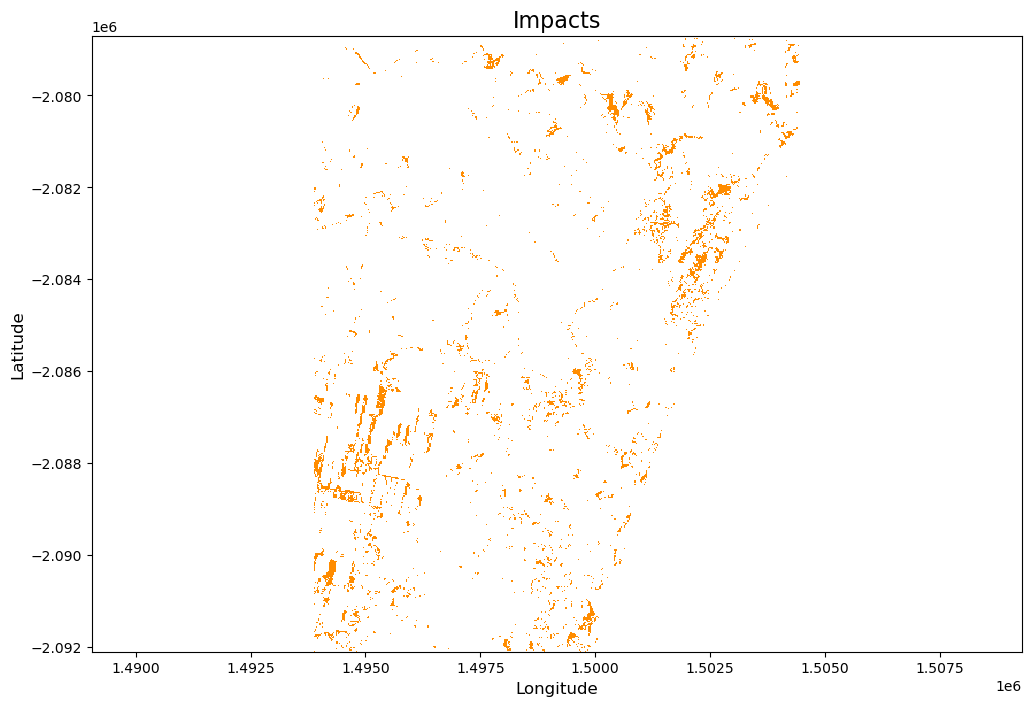

In [51]:
from myfunctions import plot_impact
plot_impact(
    data=Impact68.VegAmtRed,
    cmap=cmap,
    norm=norm,
    figsize=(12, 8),
    title='Impacts'
)

In [52]:
# Make a mask of 1 for the 'impact' class No. 67 'vegetation amount - gain' 
VegGainExt = np.where(
        (
        ((obs_change_l3.modification == 216112) |
        (obs_change_l3.modification == 216124) |
        (obs_change_l3.modification == 220112) |        
        (obs_change_l3.modification == 220124))
        ),
        64,
        0,
)

In [53]:
VegGainExtxa = xr.DataArray(
    data=VegGainExt,
    coords=obs_change_vcov.vcov_change.coords,
    dims=obs_change_vcov.vcov_change.dims,
    name="64: Vegetation extent gain",
    attrs=None,
)

In [54]:
Impact64 = VegGainExtxa.to_dataset(name="VegGainExt")

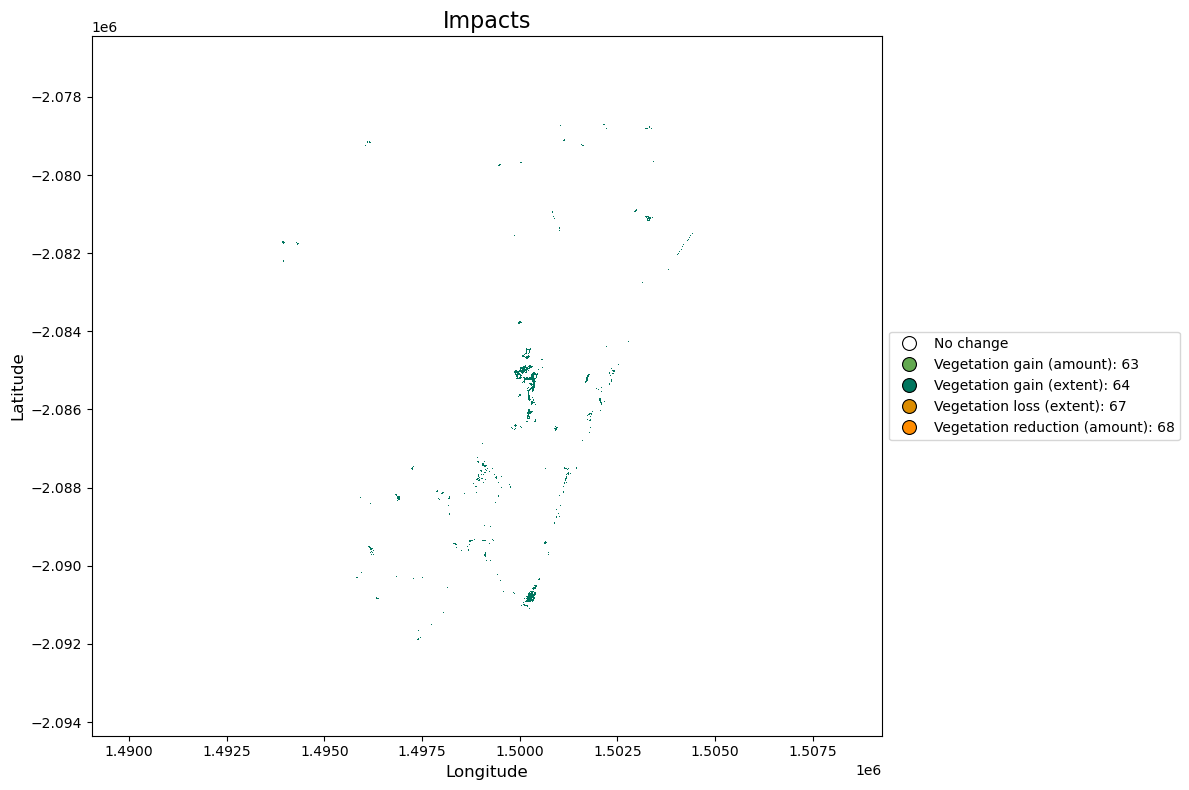

In [55]:
from dea_tools.landcover import plot_land_cover, lc_colourmap, make_colorbar
from myfunctions import plot_impact_mychanges
plot_impact_mychanges(
    data=Impact64.VegGainExt,
    cmap=cmap,
    norm=norm,
    figsize=(12, 8),
    title='Impacts'
)

In [56]:
# Make a mask of 1 for the 'impact' class No. 67 'vegetation extent loss' 
VegLossExt = np.where(
        (
        ((obs_change_l3.modification == 112216) |
        (obs_change_l3.modification == 124216) |
        (obs_change_l3.modification == 112220) |        
        (obs_change_l3.modification == 124220))
        ),
        67,
        0,
)

In [57]:
VegLossExtxa = xr.DataArray(
    data=VegLossExt,
    coords=obs_change_vcov.vcov_change.coords,
    dims=obs_change_vcov.vcov_change.dims,
    name="Vegetation loss extent (Impact No. 67)",
    attrs=None,
)

In [58]:
Impact67 = VegLossExtxa.to_dataset(name="VegLossExt")

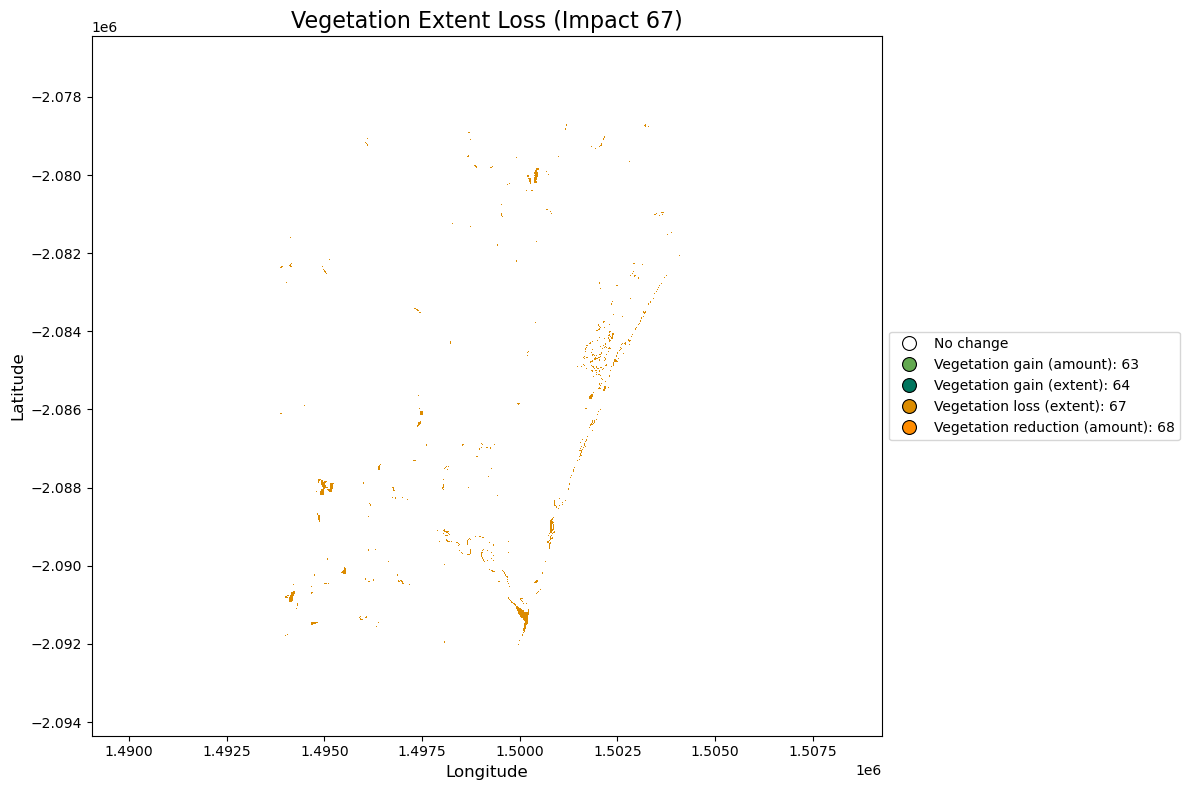

In [59]:
from dea_tools.landcover import plot_land_cover, lc_colourmap, make_colorbar
from myfunctions import plot_impact_mychanges
plot_impact_mychanges(
    data=Impact67.VegLossExt,
    cmap=cmap,
    norm=norm,
    figsize=(12, 8),
    title='Vegetation Extent Loss (Impact 67)'
)

### Generate summary maps of impacts
Now, combine the two layers to generate a combined map of impacts (i.e., Impacts 63 and 68).

### Generate summary maps of impacts
Now, combine the layers to generate a combined map of listed impacts (in this case, 63, 64, 67 and 68).

In [60]:
Impacts = VegGainAmtxa.to_dataset(name="VegGainAmt")
Impacts ["VegGainExt"] = VegGainExtxa
Impacts ["VegLossExt"] = VegLossExtxa
Impacts ["VegAmtRed"] = VegAmtRedxa

Impacts ["Sum"] = ((VegLossExtxa)+ (VegGainExtxa) + (VegGainAmtxa) + (VegAmtRedxa))

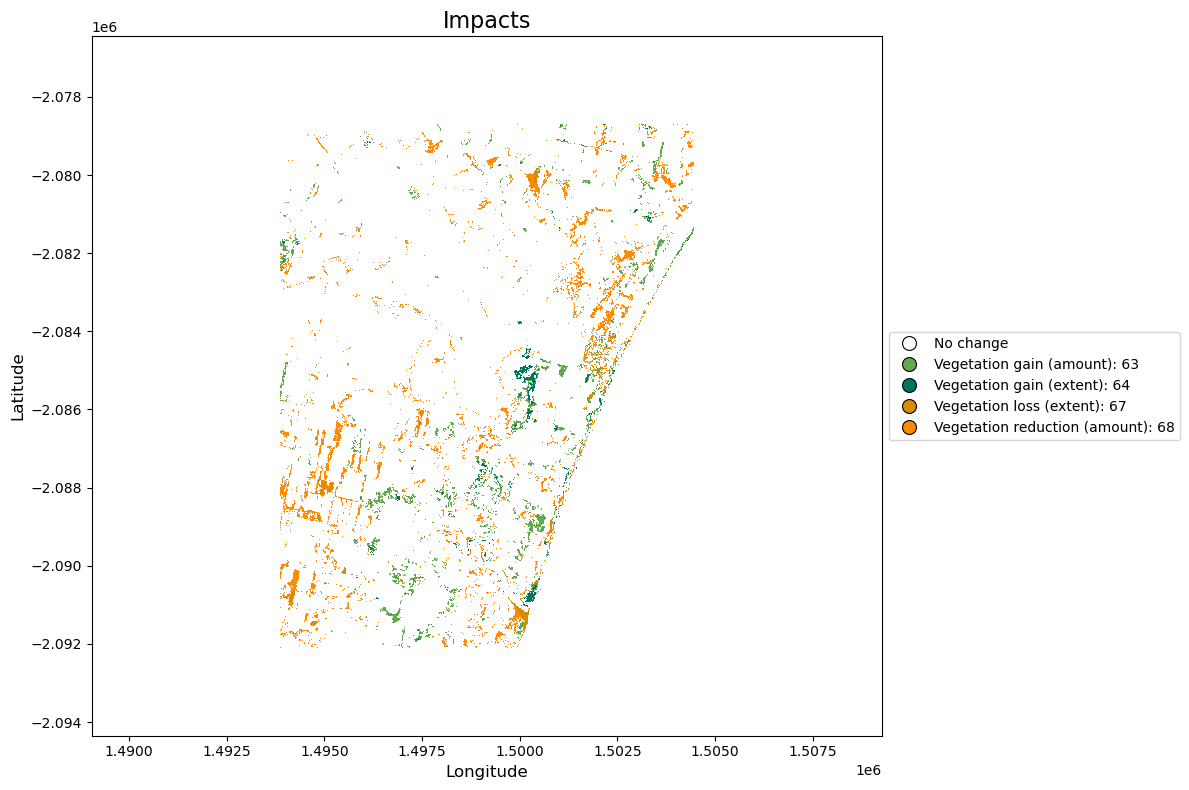

In [61]:
from myfunctions import plot_impact_mychanges
plot_impact_mychanges(
    data=Impacts.Sum,
    cmap=cmap,
    norm=norm,
    figsize=(12, 8),
    title='Impacts'
)